# PyMC 4.0 Release Announcement

We, the PyMC core development team, are incredibly excited to announce the release of a major rewrite of PyMC3 (now called just PyMC): `4.0`. This marks the first major new version in over 10 years. There are many exciting new updates that we will talk about in this and upcoming blog posts. 

## Full API compatibility for model building

To get the main question out of the way: Yes, you can just keep your existing PyMC modeling code without having to change anything (in most cases) and get all the improvements for free. The only thing most users will have to change is the import from `import pymc3 as pm` to `import pymc as pm`. For more information, see the [quick migration guide](https://www.pymc-labs.io/blog-posts/the-quickest-migration-guide-ever-from-pymc3-to-pymc-v40/). If you are using more advanced features of PyMC beyond the modeling API, you might have to change some things.

## It's now called PyMC instead of PyMC3
First, the biggest news: **PyMC3 has been renamed to PyMC. PyMC3 version 3.x will stay under the current name to not break production systems but future versions will use the PyMC name everywhere.** While there were a few reasons for this, the main one is that PyMC3 4.0 is quite confusing.

## What about PyMC4?
If you don't know what PyMC4 is, you can just skip this section. In brief, it was an experiment we did using TensorFlow Probability as a backend which we gave up on. The motivation for abandoning this is described in our previous post ["The Future of PyMC3, or: Theano is Dead, Long Live Theano"](https://pymc-devs.medium.com/the-future-of-pymc3-or-theano-is-dead-long-live-theano-d8005f8a0e9b)

In general, you should refer to the new version as "PyMC 4.0" or "PyMC v4".

## Theano -> Aesara

Getting to know other tensor libraries like TensorFlow and PyTorch better made us realize how amazing and unique `Theano` really is. It has a mature and hackable code base and a simple graph representation that allows easy graph manipulations, something that's very useful for probabilistic programming languages.

So we went ahead and forked the library and undertook a massive cleaning up of the code-base (this charge was led by [Brandon Willard](https://twitter.com/brandontwillard)), removing swaths of old and obscure code, and restructuring the entire library to be more developer friendly.

This rewrite motivated renaming the package to [`Aesara`](https://github.com/aesara-devs/aesara) (Theano's daughter in Greek mythology). Quickly, a new developer team focused around improving `aesara` independent of `PyMC`.

One major new feature are the two new computational backends: `JAX` and `numba`. The way this works is that `aesara` is best understood as a computational graph library that allows you to build a computational graphs out of array-operations (additions, multiplications, dot-products, indexing, for-loops). From this graph representation, we can do various things:
* graph optimizations like `log(exp(x)) -> x`
* symbolic rewrites like `N(0, 1) + a` -> `N(a, 1)`
* compilation of that graph to various computational backends.

Previously, `theano` supported Python and C as computational backends. But with `aesara` it is now possible, and in fact quite easy, to add new computational backends. We have currently added a `JAX` backend that comes with GPU support (see [this blog post](https://martiningram.github.io/mcmc-comparison/) for some impressive speed-ups using GPUs for sampling). We're also in the process of adding a `numba` backend.

## What's new in PyMC 4.0?

### New JAX backend for faster sampling

By far the most exciting new feature are the new computational backends and the associated speed-ups. 

As mentioned above, `aesara` provides a representation of the model logp graph in form of various `aesara` `Ops` (operators) which represent the computations to be be performed. For example `exp(x + y)` would be an `Add` `Op` with two input arguments `x` and `y`. The result of the `Add` `Op` is then inputted into an `exp` `Op`.

This computation graph doesn't say anything about how we actually *execute* this graph. Before, we would transpile this graph to C-code which would then get compiled, loaded into Python as a C-extension, and then executed. But now, we can just transpile this graph to `JAX` instead.

While this by itself is already pretty exciting, because `JAX` is capable of a whole bunch of low-level optimizations which lead to faster logp evaluations, we still have our samplers written in Python, so there is still some call-overhead. 

To get rid of this, we can link the `JAX` graph produced by `aesara` with a sampler also written in `JAX`. That way, the model logp evaluation *and* the sampler are one big JAX graph that gets optimized and executed without any Python call-overhead. We currently support a NUTS implementation provided by `numpyro` as well as `blackjax`.

Early experiments and benchmarks show impressive speed-ups. Here is a small example of how much faster this is on a fairly small and simple model: the hierarchical linear regression of the famous Radon example.

In [ ]:
# Standard imports
import numpy as np
import arviz as a
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
np.set_printoptions(2)

In order to do side-by-side comparisons, I installed both, the old `PyMC3` and `Theano` as well as the new `PyMC 4.0` and `Aesara` into this environment. You will only need the new packages of course.

In [ ]:
# PyMC Imports
import pymc3 as pm3 # PyMC3 3.11
import pymc as pm4 # PyMC 4.0

# Aesara and Theano imports
import theano.tensor as tt # used by PyMC3 3.11
import aesara.tensor as at # used by PyMC 4.0

Load in radon dataset and preprocess:

In [8]:
data = pd.read_csv("/Users/twiecki/personal/homepage/WhileMyMCMCGentlySamples/content/radon.csv")
#data = pd.read_csv(pm4.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"].astype(theano.config.floatX)

county_idx, counties = pd.factorize(data.county)
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idx)),
}

Next, let's define our model inside of a function. Note that we provide `pm`, our PyMC library, as an argument here. This allows us to create this model in `pymc3` or `pymc 4.0`. Here you can also see that most models that work in `pymc3` also work in `pymc 4.0` without any code change, you only need to change your imports.

In [29]:
def build_model(pm, **kwargs):
    with pm.Model(coords=coords) as hierarchical_model:
        mu_a = pm.Normal("mu_a", mu=0.0, sigma=10)
        sigma_a = pm.HalfNormal("sigma_a", 5.0)
        mu_b = pm.Normal("mu_b", mu=0.0, sigma=10)
        sigma_b = pm.HalfNormal("sigma_b", 5.0)
        a = pm.Normal("a", dims="county") * sigma_a + mu_a
        b = pm.Normal("b", dims="county") * sigma_b + mu_b
        eps = pm.HalfNormal("eps", 5.0)
        radon_est = a[county_idx] + b[county_idx] * data.floor.values
        radon_like = pm.Normal(
            "radon_like", mu=radon_est, sigma=eps, observed=data.log_radon, 
            dims="obs_id"
        )
        
    return hierarchical_model

Create and sample model in `pymc3`, nothing special:

In [32]:
%%time
model_pymc3 = build_model(pm3)
with model_pymc3:
    idata_pymc3 = pm3.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 50 div

CPU times: user 4.23 s, sys: 244 ms, total: 4.47 s
Wall time: 12.7 s


Create and sample model in `pymc` 4.0, also nothing special:

In [33]:
%%time
model_pymc4 = build_model(pm4)
with model_pymc4:
    idata_pymc4 = pm4.sample()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
/Users/twiecki/projects/pymc/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]
INFO:pymc:NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your Python environment has Theano(-PyMC) 1.1.2 installed, but you are importing PyMC 4.0.0b1 which uses Aesara as its backend.
For PyMC 4.0.0b1 to work as expected you should uninstall Theano(-PyMC).
See https://github.com/pymc-devs/pymc/wiki for update instructions.
!!!!!!!!!!!!!!!!!!!!!!!!

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 147 div

CPU times: user 4.54 s, sys: 254 ms, total: 4.79 s
Wall time: 16.4 s


Now, lets use a JAX sampler instead. Here we use the one provided by `numpyro`:

In [ ]:
import pymc.sampling_jax

In [35]:
%%time
with model_pymc4:
    idata = pm4.sampling_jax.sample_numpyro_nuts(progress_bar=False)

Compiling...


/Users/twiecki/projects/pymc/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Compilation time =  0 days 00:00:00.267406
Sampling...
Sampling time =  0 days 00:00:05.143948
Transforming variables...
Transformation time =  0 days 00:00:00.017413
CPU times: user 7.99 s, sys: 47.2 ms, total: 8.04 s
Wall time: 5.53 s


/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/aesara/graph/opt.py:279: UserWarning: Supervisor is not added. Please build a FunctionGraphvia aesara.compile.function.types.std_graph()or add the Supervisor class manually.
  sub_prof = optimizer.optimize(fgraph)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.9/site-packages/aesara/graph/opt.py:279: UserWarning: Supervisor is not added. Please build a FunctionGraphvia aesara.compile.function.types.std_graph()or add the Supervisor class manually.
  sub_prof = optimizer.optimize(fgraph)


In [36]:
16.4 / 5.53

2.9656419529837246

That's a speed-up of 3x -- for a single-line code change! And this is just running things on the CPU, we can just as easily run this on the GPU where we saw even more impressive speed-ups (especially as we scale the data).

Again, for a more proper benchmark that also compares this to Stan, see [this blog post](https://martiningram.github.io/mcmc-comparison/).

#### Numba backend

The other backend that we are very excited about is `numba`. We will talk more about this as it becomes more mature.

#### The next step: Samplers written in `aesara`

While this current approach is already quite exciting, we can take this one step further. The setup we showed above has the model logp graph (represented in `aesara` compiled to `JAX`. This `JAX` function we then linked to a sampler written in `JAX`.

This is suboptimal for two reasons:
1. For new backends, like `numba`, we need to rewrite the sampler also in `numba`.
2. While we get low-level optimizations from `JAX` on the logp+sampler JAX-graph, we do not get any high-level optimizations, which is what `aesara` is great at.

With [`aehmc`](https://www.github.com/aesara-devs/aehmc) and [`aemcmc`](https://www.github.com/aesara-devs/aemcmc) the `aesara` devs are developing a library of samplers *written in `aesara`*. That way, our model logp, consisting out of `aesara` `Ops` can be combined with the sampler logic, also consisting out of `aesara` `Ops`, into one big `aesara` graph.

On that graph, `aesara` can do high-level optimizations to get a more efficient graph representation, and then compile it to whatever backend we want: `JAX`, `numba`, `C`, or whatever other backend we add in the future.

If you think this is interesting, definitely check out these packages and consider contributing, this is where the next round of innovation will come from!




## Better integration into `aesara`

The next feature we are excited about is a better integration of `PyMC` and `aesara`.

In `PyMC3 3.x`, the random variables (RVs) created by e.g. calling `x = pm.Normal('x')` were not truly `theano` `Ops` which you would integrate nicely with the rest of `theano`. This created a lot of issues, limitations, and complexities in the library.

`Aesara` now provides a proper `RandomVariable` Op which perfectly integrates with the rest of the other `Ops`. 

This is a major change in `4.0` and lead to huge swaths of code getting removed and greatly simplified. In many ways, this change is much more exciting than the different computational backends, but the effects are not quite as visible to the user.

There are a few cases, however, where you can see the benefits.

### Faster posterior predictive sampling

In [86]:
%%time

with model_pymc3:
    pm3.sample_posterior_predictive(idata_pymc3)

CPU times: user 5.04 s, sys: 1.12 s, total: 6.16 s
Wall time: 6.17 s


In [87]:
%%time

with model_pymc4:
    pm4.sample_posterior_predictive(idata_pymc4)

CPU times: user 1.59 s, sys: 32 ms, total: 1.62 s
Wall time: 1.6 s


On this model, we get a speed-up of almost 4x. This will vary on the model but in general, on models where predictive sampling was already fast, it will probably not be much faster, but on models where predictive sampling was really slow, you can expect a big speed-up.

The reason for this is that predictive sampling is now happening as part of the `aesara` graph. Before, we were walking through the random variables in Python which was not only slow, but also very error-prone, so a lot of dev time was spent fixing bugs and rewriting this complicated piece of code. In `PyMC` 4.0, all that complexity is gone.

## Work with RVs just like with Tensors

In PyMC3, RVs as returned by e.g. `pm.Normal("x")` behaved somewhat like a Tensor variable, but not *quite*. In PyMC 4, RVs are first-class Tensor variables that can be operated on much more freely.

In [13]:
with pm3.Model():
    x3 = pm3.Normal("x")
    
with pm4.Model():
    x4 = pm4.Normal("x")

In [14]:
type(x3)

pymc3.model.FreeRV

In [15]:
type(x4)

aesara.tensor.var.TensorVariable

Through the power of [`aeppl`](https://github.com/aesara-devs/aeppl) (a new low-level library that provides core building blocks for probabilistic programming languages on top of `aesara`), PyMC 4.0 allows you to do even more operations directly on the RV as was possible before.

For example, we can `clip()` a RV using `aesara`'s `clip()` function. Also, calling `.eval()` on a RV samples a random draw from the RV, this is also new in PyMC 4.0 and makes things more consistent and allows easy interactions. 

In [24]:
at.clip(x4, 0, np.inf).eval()

array(1.39867239)

<AxesSubplot:ylabel='Count'>

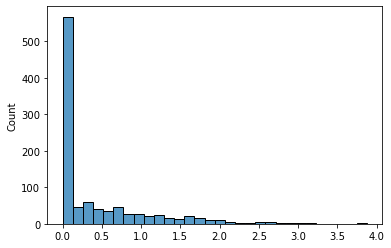

In [36]:
trunc_norm = [at.clip(x4, 0, np.inf).eval() for _ in range(1000)]
sns.histplot(np.asarray(trunc_norm))

As you can see, negative values are clipped to be 0. And you can use this, just like any other transform, directly in your model.

But there are other things you can do as well, like `stack()` RVs, and then index into them with a binary RV.

In [69]:
with pm4.Model():
    x = pm4.Uniform("x", lower=-1, upper=0)
    y = pm4.Uniform("y", lower=0, upper=1)
    xy = at.stack([x, y])
    index = pm4.Bernoulli("index", p=0.5)

for _ in range(5):
    print("Sampled value = {:.2f}".format(xy[index].eval()))

Sampled value = -0.84
Sampled value = 0.55
Sampled value = 0.70
Sampled value = -0.66
Sampled value = -0.34


As you can see, depending on whether `index` is `0` or `1` we either sample from the negative or positive uniform. This also supports fancy indexing, so you can manually create complicated mixture distribution using a `Categorical` like this:

In [55]:
with pm4.Model():
    x = pm4.Uniform("x", lower=-1, upper=0)
    y = pm4.Uniform("y", lower=0, upper=1)
    z = pm4.Uniform("z", lower=1, upper=2)
    xyz = at.stack([x, y, z])
    index = pm4.Categorical("index", [.3, .3], shape=3)

for _ in range(5):
    print("Sampled value = {}".format(xyz[index].eval()))

Sampled value = [1.35927217 0.20451265 1.35927217]
Sampled value = [ 1.01280942 -0.1336057   0.45787874]
Sampled value = [1.15299912 0.59138617 1.15299912]
Sampled value = [1.54220526 1.54220526 1.54220526]
Sampled value = [-0.83659795  1.43210203 -0.83659795]


## Support for for-loops in `scan`

Sometimes you would like to create RVs in for-loops. This is very common in timeseries models. Wouldn't it be cool if we could write a Gaussian random walk like this:

In [91]:
with pm4.Model():
    y = [0]
    for t in range(5):
        y_t = pm4.Normal(f"y_{t}", sigma=.1)
        y.append(y[-1] + y_t)
    
    random_walk = at.stack(y)

random_walk.eval()

array([ 0.  ,  0.01,  0.09, -0.  ,  0.12,  0.16])

While that is possible, it is incredibly inefficient because creation and keeping track of individual RVs is very costly. That's why in general we advise users to do everything vectorized. 

This is also an area in which Stan shines where this is efficiently possible. With `aeppl`, however, we now have support for `aesara`-style for loops which come in the form of the `scan` operator. With this, we can create RVs *inside* `aesara.scan()`. So the above for-loop can be equivalently rewritten as:

In [137]:
with pm4.Model():
    random_walk, _ = aesara.scan(
        fn=lambda Y_tm1: Y_tm1 + pm4.Normal.dist(sigma=.1),
        outputs_info=[{"initial": at.as_tensor([0.0])}],
        n_steps=100,
        name="Y"
    )

plt.plot(random_walk.eval())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.8/site-packages/aesara/tensor/c_code/dimshuffle.c'

The syntax is famously cryptic. In brief, we define a `lambda` function we pass to `fn` that is executed inside the for-loop retrieving the previous value. The key here is that when we define the RV inside the `scan`, that this is now efficient in PyMC 4.0.

This feature makes writing various other timeseries distributions much simpler and more flexible.

## Better (and Dynamic) Shape Support

Another big improvement in `PyMC` 4.0 is in how shapes are handled internally. Before this was also a bunch of complicated Python code because we did not make proper use of `aesara`. Now, everything is completely offloaded to `aesara`. As a sid-effect, this better shape support also allows dynamic RV shapes, where the shape depends on another RV:

In [66]:
with pm4.Model() as m:
    x = pm4.Poisson('x', 2)
    z = pm4.Normal('z', shape=x)
    
for _ in range(5):
    print("Value of z = {}".format(z.eval()))

Value of z = [-0.36 -0.87]
Value of z = [-0.43]
Value of z = [-1.25 -0.07  0.6 ]
Value of z = [-0.4   1.94]
Value of z = [1.58]


As you can see, the shape of `z` changes with each draw according to the integer sampled by `x`.

Note, however, that this does not yet work for posterior inference (i.e. sampling). The reason is that the trace backend (`arviz.InferenceData`) as well as samplers in this case also must support changing dimensionality (like reversible-jump MCMC). There are plans to add this.

## Conditioning & Causal Inference

In [67]:
# 1. define joint P(mu, sigma, x)
with pm4.Model() as m:
    mu = pm4.Normal("mu", 0, 1)
    sigma = pm4.HalfNormal("sigma", 1)
    x = pm4.Normal("obs", mu, sigma)

# 2. Generate N samples from P(x|mu=0, sigma=0.1) 
N = 10
cond_x = aesara.function([mu, sigma], x)
_x = np.array([cond_x(0, 0.1) for _ in range(N)])

print("10 samples from P(x | mu=0, sigma=0.1) = {}".format(_x))

10 samples from P(x | mu=0, sigma=0.1) = [ 0.03 -0.15  0.07 -0.02  0.12 -0.01  0.07  0.08 -0.05  0.01]


## Better NUTS initialization

We have also fixed an issue with the default NUTS warm-up which sometimes lead to the sampler getting stuck for a while. While fixing this issue, [Adrian Seyboldt](https://twitter.com/aseyboldt) also came up with a new initialization method that uses the gradients to estimate a better mass-matrix. You can use this (still experimental) feature by calling `pm.sample(init="jitter+adapt_diag_grad")`.

Let's try this on the hierarchical regression model from above:

In [95]:
model_pymc4_grad, idata_pymc4_grad = build_model(pm4, init="jitter+adapt_diag_grad")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
/Users/twiecki/projects/pymc/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your Python environment has Theano(-PyMC) 1.1.2 installed, but you are importing PyMC 4.0.0b1 which uses Aesara as its backend.
For PyMC 4.0.0b1 to work as expected you should uninstall Theano(-PyMC).
See https://github.com/pymc-devs/pymc/wiki for update instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
You are importing PyMC 4.0.0b1, but your environment also has the legacy version PyMC3 3.11.4 installed.

/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/twiecki/miniforge3/envs/pymc4b1/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


The first thing to observe as that we did not get any divergences this time. Comparing the effective sample size of the default and grad-based initialization, we can also see that it leads to much better sampling for certain parameters:

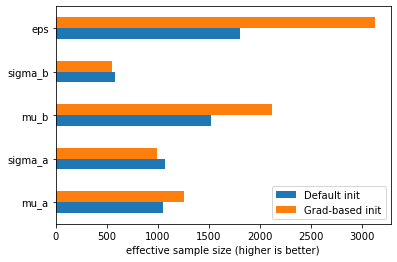

In [126]:
pd.DataFrame({"Default init": az.summary(idata_pymc4, var_names=["~a", "~b"])["ess_bulk"],
              "Grad-based init": az.summary(idata_pymc4_grad, var_names=["~a", "~b"])["ess_bulk"]}).plot.barh()
plt.xlabel("effective sample size (higher is better)");

## What's not yet working

Currently we are still missing a few features from PyMC3. These should not be hard to add and will be there for the 4.0 stable release. The list includes:

* Timeseries distributions
* Mixture Distributions

## Accolades

While many people contributed to this effort, we would like to highlight the outstanding contributions of [Brandon Willard](https://brandonwillard.github.io), [Ricardo Vieira](https://github.com/ricardoV94), and [Kaustubh Chaudhari](https://github.com/kc611) who did most of the work.